In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Preprocessing movies data frame

In [2]:
movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')

In [3]:
movies.head(2)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN


In [4]:
movies.shape

(3883, 3)

In [5]:
movies.describe()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
count,3883,100,51
unique,3883,73,45
top,1::Toy Story (1995)::Animation|Children's|Comedy,y,ma
freq,1,4,3


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


-> As per the documentation, titles are identical to titles provided by the IMDB. "Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western" are the unique genres.

In [7]:
# Dropping unwanted features.
movies.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace = True)

In [8]:
# Creating 'Movie_ID', Title' and 'Genres' features.
movies['Movie_ID'] = movies.iloc[:,0].apply(lambda rows: rows.split('::')[0])
movies['Title'] = movies.iloc[:,0].apply(lambda rows: rows.split('::')[1])
movies['Genres'] = movies.iloc[:,0].apply(lambda rows: rows.split('::')[-1])
movies.drop('Movie ID::Title::Genres', axis = 1, inplace=True) # Dropping the original feature. 
movies.head(2)

,Movie_ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [9]:
movies.Movie_ID = movies.Movie_ID.astype(int)

In [10]:
# Getting all the genres for a movie
movies.Genres = movies.Genres.apply(lambda x : x.split('|'))
movies = movies.explode('Genres')
movies.head(2)

,Movie_ID,Title,Genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's


In [11]:
# Making Children's just children to avoid complications in the future during bag of words.
movies.Genres = movies.Genres.apply(lambda row : 'Children' if row == "Children's" else row) 

In [12]:
actual_Geners = ['Action', 'Adventure', "Animation", "Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
actual_Geners = [vals.lower() for vals in actual_Geners] # Converting everything to lower_case
len(actual_Geners), movies.Genres.nunique() 
# There is a huge difference in number of Genres. 

(18, 87)

In [13]:
# Some genres appear to be repeating or incorrect.
movies.Genres.unique()

array(['Animation', 'Children', 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery',
       "Don't Be a Menace to South Central While Drinking Your Juice in the",
       'Film-Noir', 'Dram',
       'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):',
       'Western', 'Chil', '', 'Fantas', 'Dr', 'D',
       'Wonderful, Horrible Life of Leni Riefenstahl, The (Die Macht der B',
       'Documenta', 'Wester',
       'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995',
       'Fant', 'Music', 'Childre',
       'Institute Benjamenta, or This Dream People Call Human Life (1995):',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bo',
       'Childr',
       "My Life and Times With Antonin Artaud (En compagnie d'Antonin Arta",
       'Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la',
       'Rom', 'Animati', 'Co

In [14]:
# Lets try some basic techniques and see if we can try to clean this.
# Firstly converting everthing to lower case. 
movies['Genres'] = movies['Genres'].apply(str.lower)
movies['Genres'].nunique()
# No effect

87

In [15]:
# Removing unnessary spaces from the categories. 
def del_spaces(row):
    row=row.split()
    return ' '.join(row)
movies['Genres'] = movies['Genres'].apply(del_spaces)
movies['Genres'].nunique()
# No effect again. We have to dive deep now. 

87

In [16]:
movies['Temp'] = movies['Genres'].apply(lambda row : True if row not in actual_Geners else False)

In [17]:
# Some Genres appear to be the name of the movie itself.
# Using 11 as the limit since documentary Genre has the highest length and anything ant length above 11 is incorrect. 
np.array([vals for vals in movies[(movies['Temp'] == True)]['Genres'].unique() if len(vals) > 11])

array(["don't be a menace to south central while drinking your juice in the",
       'umbrellas of cherbourg, the (parapluies de cherbourg, les) (1964):',
       'wonderful, horrible life of leni riefenstahl, the (die macht der b',
       'englishman who went up a hill, but came down a mountain, the (1995',
       'institute benjamenta, or this dream people call human life (1995):',
       'dr. strangelove or: how i learned to stop worrying and love the bo',
       "my life and times with antonin artaud (en compagnie d'antonin arta",
       'old lady who walked in the sea, the (vieille qui marchait dans la',
       'return of martin guerre, the (retour de martin guerre, le) (1982)',
       'double life of veronique, the (la double vie de véronique) (1991)',
       'garden of finzi-contini, the (giardino dei finzi-contini, il) (19',
       'seven samurai (the magnificent seven) (shichinin no samurai) (195',
       "swept away (travolti da un insolito destino nell'azzurro mare d'a",
    

In [18]:
# Since there is no description of the movie given, lets just assign a new genre called others to these first. 
movies['Genres'] = movies['Genres'].apply(lambda row : 'Others' if len(row) > 11 else row)
[vals for vals in movies[(movies['Temp'] == True)]['Genres'].unique() if len(vals) > 11], movies.Genres.nunique()
# All the unknown Genres have been filled

([], 63)

In [19]:
actual_Geners.append('Others') # Adding this genre to the original list

In [20]:
# Some Genres have been incorrectly entered.
np.array([vals for vals in movies[(movies['Temp'] == True)]['Genres'].unique() if len(vals) <= 11])

array(['Others', 'dram', 'chil', '', 'fantas', 'dr', 'd', 'documenta',
       'wester', 'fant', 'music', 'childre', 'childr', 'rom', 'animati',
       'come', "children'", 'sci-f', 'adv', 'adventu', 'horro', 'docu',
       's', 'sci-', 'document', 'th', 'roman', 'documen', 'we', 'f', 'ro',
       'r', 'sci', 'chi', 'thri', 'adventur', 'advent', 'acti', 'roma',
       'a', 'comed', 'com', 'thrille', 'wa', 'horr'], dtype='<U9')

In [21]:
# For single digit or 0 length Genres, we'll have to go with others Genre again as we do not have the description of the movies. 
movies['Genres'] = movies['Genres'].apply(lambda row : 'Others' if len(row) <= 1 else row)
movies.Genres.nunique()

57

In [22]:
# Almost all the values has the prefix of one of the genres. 
np.array([vals for vals in movies[(movies['Temp'] == True)]['Genres'].unique() if len(vals) <= 11])

array(['Others', 'dram', 'chil', 'fantas', 'dr', 'documenta', 'wester',
       'fant', 'music', 'childre', 'childr', 'rom', 'animati', 'come',
       "children'", 'sci-f', 'adv', 'adventu', 'horro', 'docu', 'sci-',
       'document', 'th', 'roman', 'documen', 'we', 'ro', 'sci', 'chi',
       'thri', 'adventur', 'advent', 'acti', 'roma', 'comed', 'com',
       'thrille', 'wa', 'horr'], dtype='<U9')

In [23]:
def genre_clean(row):
    for vals in actual_Geners:
        if vals.startswith(row):
            return vals
    return 'Others'

In [24]:
# Cleaning the genres. 
movies['Genres'] = movies['Genres'].apply(genre_clean)

In [25]:
# All Genres have been cleaned. 
movies['Genres'].unique()

array(['animation', 'children', 'comedy', 'adventure', 'fantasy',
       'romance', 'drama', 'action', 'crime', 'thriller', 'horror',
       'sci-fi', 'documentary', 'war', 'musical', 'mystery', 'Others',
       'film-noir', 'western'], dtype=object)

In [26]:
movies.drop('Temp', axis=1, inplace=True)

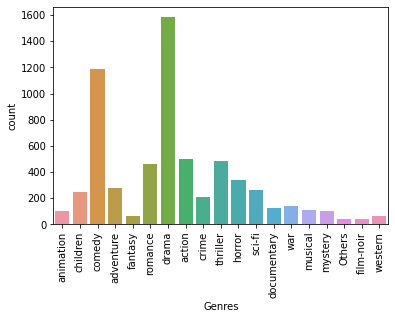

In [27]:
sns.countplot(movies.Genres)
plt.xticks(rotation='90')
plt.show()
# Any movie which has drama or comedy is mostly watched.

In [28]:
# Grouping again to get genres for each movie, also converting each row to a space seperated string.
movies = movies.groupby(['Movie_ID', 'Title'])['Genres'].unique().to_frame().reset_index()
movies.Genres = movies.Genres.apply(lambda row : ' '.join(row))
movies.head(3)

,Movie_ID,Title,Genres
0,1,Toy Story (1995),animation children comedy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance


In [29]:
# Getting bag of words for genre feature. 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=actual_Geners)
gen = vectorizer.fit_transform(movies['Genres'])
genre_array = gen.toarray()

In [30]:
movies = movies.join(pd.DataFrame(genre_array, columns = vectorizer.get_feature_names_out()))
movies.drop('Genres', inplace=True, axis= 1)
movies.head(3)

,Movie_ID,Title,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western,Others
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
# We can extract the release year of movies from the Title feature
movies['Release_Yr'] = movies['Title'].apply(lambda row: row[-5:-1])
movies['Release_Yr'] = movies['Release_Yr'].apply(lambda row: np.nan if row not in str(np.arange(1900, 2020)) else row)
movies.head(3)

,Movie_ID,Title,action,adventure,animation,children,comedy,crime,documentary,drama,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,Others,Release_Yr
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1995


In [32]:
movies['Release_Yr'].isna().sum()

23

In [33]:
# Imputing the missing values with the mode. 
movies['Release_Yr'].fillna(movies['Release_Yr'].mode()[0], inplace=True)

In [34]:
movies.isna().sum() # We do not have any missing values

Movie_ID       0
Title          0
action         0
adventure      0
animation      0
children       0
comedy         0
crime          0
documentary    0
drama          0
fantasy        0
film-noir      0
horror         0
musical        0
mystery        0
romance        0
sci-fi         0
thriller       0
war            0
western        0
Others         0
Release_Yr     0
dtype: int64

In [35]:
# Making year as int datatype. 
movies['Release_Yr'] = movies['Release_Yr'].astype(int)

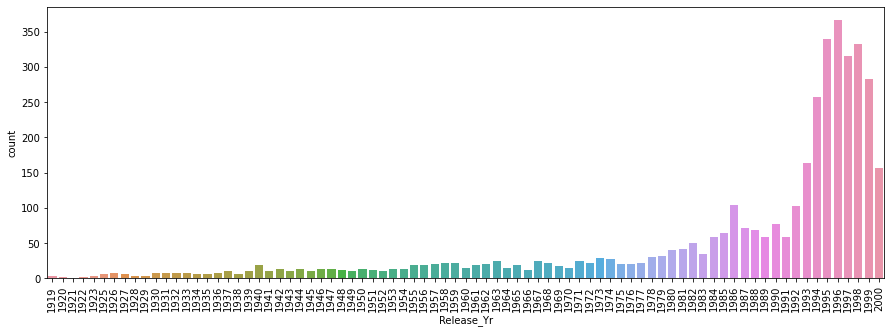

In [36]:
plt.figure(figsize=(15,5))
sns.countplot(movies.Release_Yr)
plt.xticks(rotation='90')
plt.show()

- Our Dataset contains most of the movies released in the 90s decade. 

###  Preprocessing users data frame

In [37]:
users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [38]:
users.head(2)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072


In [39]:
users['UserID'] = users.iloc[:,0].apply(lambda rows: rows.split('::')[0])
users['Gender'] = users.iloc[:,0].apply(lambda rows: rows.split('::')[1])
users['Age'] = users.iloc[:,0].apply(lambda rows: rows.split('::')[2])
users['Occupation'] = users.iloc[:,0].apply(lambda rows: rows.split('::')[3])
users['Zip-code'] = users.iloc[:,0].apply(lambda rows: rows.split('::')[4])

In [40]:
users.drop('UserID::Gender::Age::Occupation::Zip-code', axis = 1, inplace=True)
users.head(2)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072


#### Users feature description

- Gender is denoted by a "M" for male and "F" for female


- Age is chosen from the following ranges = (1: "Under 18"), (18: "18-24"), (25: "25-34"), (35: "35-44"), (45: "45-49"), (50: "50-55"), (56: "56+")


- Occupation is chosen from the following choices = (0: "other" or not specified), (1: "academic/educator"), (2: "artist"), (3: "clerical/admin"), (4: "college/grad student"), (5: "customer service"), (6: "doctor/health care"), (7: "executive/managerial"), (8: "farmer"), (9: "homemaker"), (10: "K-12 student"), (11: "lawyer"), (12: "programmer"), (13: "retired"), (14: "sales/marketing"), (15: "scientist"), (16: "self-employed"), (17: "technician/engineer"), (18: "tradesman/craftsman"), (19: "unemployed"), (20: "writer")

In [41]:
users.shape

(6040, 5)

In [42]:
# Converting these columns to int data type for replacing. 
users.UserID = users.UserID.astype(int)
users.Occupation = users.Occupation.astype(int)
users.Age = users.Age.astype(int)

In [43]:
# Occupation's order does not make sense as it a non ordinal feature. Lets replace the numbers with actual names
users['Occupation'] = users['Occupation'].replace({0: "other or not specified", 1: "academic/educator", 2: "artist", 
                                                   3: "clerical/admin", 4: "college/grad student", 5: "customer service", 
                                                   6: "doctor/health care", 7: "executive/managerial", 8: "farmer", 
                                                   9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer", 
                                                   13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed", 
                                                   17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 
                                                   20: "writer"})

In [44]:
# Eventhough ages are ordered, replacing it with actual names for better analysis
users['Age'] = users['Age'].replace({1: "Under 18", 18: "18-24", 25: "25-34", 
                                                   35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"})

In [45]:
users.describe(exclude=np.number).T

,count,unique,top,freq
Gender,6040,2,M,4331
Age,6040,7,25-34,2096
Occupation,6040,21,college/grad student,759
Zip-code,6040,3439,48104,19


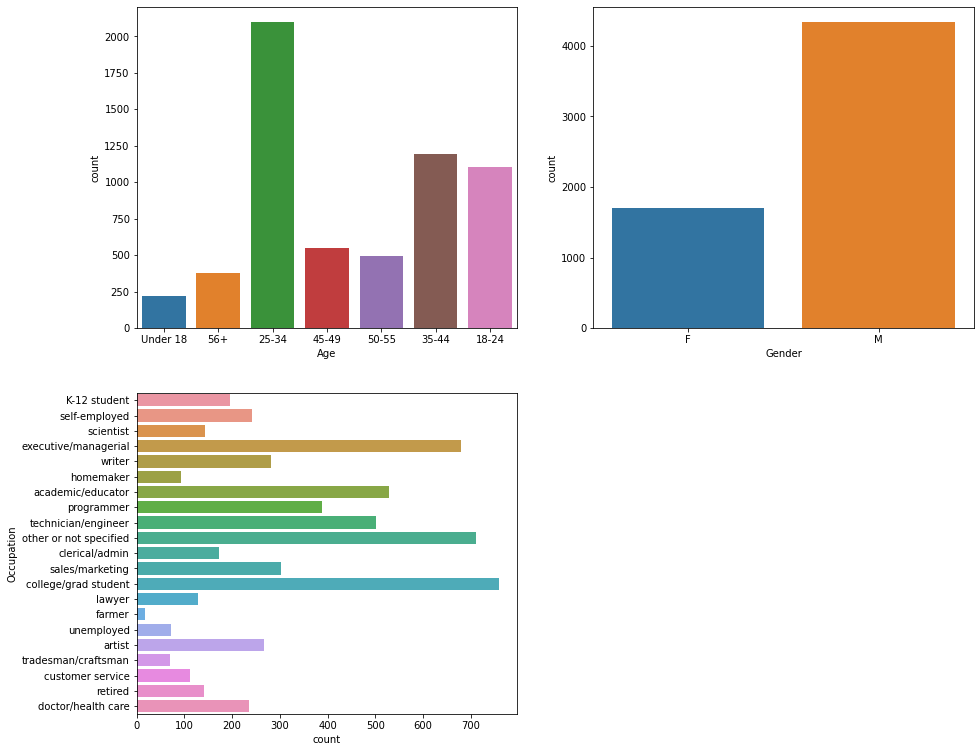

In [46]:
plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
sns.countplot(users.Age)
plt.subplot(2,2,2)
sns.countplot(users.Gender)
plt.subplot(2,2,3)
sns.countplot(y=users.Occupation)
plt.show()

##### Most of our watchers are college students and young people between ages 25-34. Also, men watch more than women. 

In [47]:
users.isna().sum() # No missing values found.

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

### Preprocessing ratings data frame

In [48]:
ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')

In [49]:
ratings.head(2)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109


In [50]:
ratings['UserID'] = ratings.iloc[:,0].apply(lambda rows: rows.split('::')[0])
ratings['Movie_ID'] = ratings.iloc[:,0].apply(lambda rows: rows.split('::')[1])
ratings['Rating'] = ratings.iloc[:,0].apply(lambda rows: rows.split('::')[2])
ratings['Timestamp'] = ratings.iloc[:,0].apply(lambda rows: rows.split('::')[3])

In [51]:
ratings.drop('UserID::MovieID::Rating::Timestamp', axis = 1, inplace=True)
ratings.head(2)

,UserID,Movie_ID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds

In [52]:
ratings.shape

(1000209, 4)

In [53]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   Movie_ID   1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [54]:
ratings.UserID = ratings.UserID.astype(int)
ratings.Movie_ID = ratings.Movie_ID.astype(int)
ratings.Rating = ratings.Rating.astype(int)
ratings.Timestamp = ratings.Timestamp.astype(int)

In [55]:
ratings.Rating.describe()
# Average rating is around 3.5

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

<AxesSubplot:xlabel='Rating', ylabel='count'>

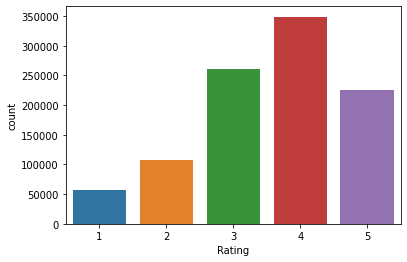

In [56]:
sns.countplot(ratings.Rating)
# People mostly rate 3,4 and 5. Very few ratings are 1 and 2. The company is mostly aquiring movies which are successful.  

In [57]:
from datetime import datetime
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
ratings['weekday'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())
ratings['weekday'] = ratings['weekday'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 
                                                 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
ratings.head(3)

,UserID,Movie_ID,Rating,Timestamp,hour,weekday
0,1,1193,5,978300760,3,Monday
1,1,661,3,978302109,4,Monday
2,1,914,3,978301968,4,Monday


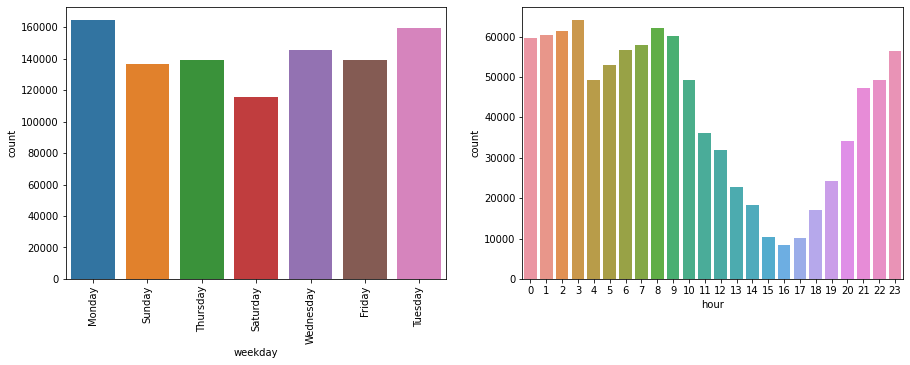

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(ratings.weekday)
plt.xticks(rotation='90')
plt.subplot(1,2,2)
sns.countplot(ratings.hour)
plt.show()

> Surpising to see more number people watching and rating on Monday and tuesday as compared to other days. However, not much can be inferred from the weekdays as there is not much variance in the count.
> Considering 11-20 as work hours, count is high for hours other than work. This seems to be an important feature as considerable variance is observed.

In [59]:
# Features no longer needed. 
ratings.drop(['weekday', 'Timestamp'], axis=1, inplace=True)

### Content based recommender system using Pearson Correlation.

In [60]:
# We do not have the same movies in both the data frames. 
ratings['Movie_ID'].nunique(), movies['Movie_ID'].nunique()

(3706, 3883)

In [61]:
# Storing the list of movies present in both movies and ratings data frames
movie_list = list(set(ratings['Movie_ID'].unique()) & set(movies['Movie_ID'].unique()))

In [62]:
# Dropping the rows which are not present in movie_list
ratings['Movie_ID'] = ratings['Movie_ID'].apply(lambda val : val if val in movie_list else np.nan)
movies['Movie_ID'] = movies['Movie_ID'].apply(lambda val : val if val in movie_list else np.nan)
ratings.dropna(inplace = True)
movies.dropna(inplace = True)

In [63]:
# Now we the same movies in both the dataframes
len(movie_list), ratings['Movie_ID'].nunique(), movies['Movie_ID'].nunique()

(3706, 3706, 3706)

In [64]:
# Avg user ratings of each movie.
avg_ratings = ratings.groupby(['Movie_ID'])['Rating'].mean().to_frame()['Rating'].values

In [65]:
# Adding a new avg ratings feature.
movies.insert(loc=2, column='Avg_user_rating', value=avg_ratings)

In [66]:
movie_ids = movies['Movie_ID'] # Storing this in a variable to use it in the future while adding the embedding features.
movies.drop(['Movie_ID'], axis=1, inplace=True) # Dropping movie_ID as it is not needed for now.
movies.set_index('Title', inplace=True)
movies.head(2)

,Avg_user_rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,Others,Release_Yr
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),4.146846,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
Jumanji (1995),3.201141,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995


In [67]:
def content_based_recomm(movie):
    '''Returns top 5 similar genre movies based on users average rating.
    Similarity is calculated using pearson correlation'''
    lst = movies.corrwith(movies.drop('Avg_user_rating', axis=1).loc[movie], axis=1).sort_values(ascending=False)[1:6].index
    film_and_ratings = {}
    for films in lst:
        film_and_ratings[films] = movies.loc[films]['Avg_user_rating']
    return sorted(film_and_ratings, key=film_and_ratings.get, reverse=True)

In [68]:
### Command execution time is high, hence executing the below lines only once and saving it on my hard drive to reuse it easily. 
### movies_recomm = pd.Series(movies.index).map(content_based_recomm)
### movies_recomm = pd.DataFrame({'Title':movies.index, 'Top_recommendations':movies_recomm.values})
### movies_recomm.to_csv('movies_recomm.csv')
pd.read_csv('movies_recomm.csv').drop('Unnamed: 0', axis=1).head(5)

,Title,Top_recommendations
0,Toy Story (1995),"['Toy Story 2 (1999)', 'Chicken Run (2000)', ""..."
1,Jumanji (1995),"['Labyrinth (1986)', 'Indian in the Cupboard, ..."
2,Grumpier Old Men (1995),"['French Twist (Gazon maudit) (1995)', 'Sabrin..."
3,Waiting to Exhale (1995),"['Welcome to the Dollhouse (1995)', 'Swimming ..."
4,Father of the Bride Part II (1995),"['Mouth to Mouth (Boca a boca) (1995)', 'In th..."


##### Hence, we can deploy "content_based_recomm" function to get 5 similar genre top rated movies based on the watched content. We can also directly deploy "movies_recomm.csv" on the server to reduce the time complexity. Content based system does not have a cold start problem. 

### Recommender System based on Cosine Similarity.

##### User-User Similarity matrix

In [1183]:
# Grouping each user and getting their avg rating and avg hour of watching
user_avgs = ratings.groupby(['UserID']).agg({'Rating':'mean', 'hour':'mean'}).reset_index()
user_avgs.head(3)

,UserID,Rating,hour
0,1,4.188679,3.792453
1,2,3.713178,2.968992
2,3,3.901961,2.215686


In [1184]:
# We have avg ratings of all the users
user_avgs.shape, users.shape

((6040, 3), (6040, 5))

In [1185]:
# Merging to get avg ratings and hours
users = users.merge(user_avgs, on='UserID')

In [1186]:
users.rename(columns={'Rating':'Avg_rating','hour':'Avg_watch_hr'}, inplace=True)
users.head(3)

,UserID,Gender,Age,Occupation,Zip-code,Avg_rating,Avg_watch_hr
0,1,F,Under 18,K-12 student,48067,4.188679,3.792453
1,2,M,56+,self-employed,70072,3.713178,2.968992
2,3,M,25-34,scientist,55117,3.901961,2.215686


In [1187]:
# Dropping zipcode as it cannot be a feature which decides similarity between users.
users.drop('Zip-code', axis=1, inplace=True)

In [1188]:
users.isna().sum() # No missing values as of now

UserID          0
Gender          0
Age             0
Occupation      0
Avg_rating      0
Avg_watch_hr    0
dtype: int64

In [1189]:
# Replacing age with ordinal values
users.Age.replace({'Under 18':0, '18-24':1, '25-34':2, '35-44':3, '45-49':4, '50-55':5, '56+':6}, inplace=True)
users.Gender.replace({'M':0, 'F':1}, inplace=True) # Replacing Gender with male as 0 and female as 1
users.set_index('UserID', inplace=True) # Making user_id as index

In [1190]:
# Scaling the entire users data frame and OHE occupation feature. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_users = pd.DataFrame(data=scaler.fit_transform(pd.get_dummies(users, columns=['Occupation'])), 
                                                 columns=pd.get_dummies(users, columns=['Occupation']).columns,
                                                 index=users.index)
scaled_users.head(3)

,Gender,Age,Avg_rating,Avg_watch_hr,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,...,Occupation_other or not specified,Occupation_programmer,Occupation_retired,Occupation_sales/marketing,Occupation_scientist,Occupation_self-employed,Occupation_technician/engineer,Occupation_tradesman/craftsman,Occupation_unemployed,Occupation_writer
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,0.803859,0.164889,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.000000,0.683405,0.129087,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.333333,0.731227,0.096334,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1191]:
from scipy.spatial.distance import cosine, pdist, squareform

In [1192]:
def cosine_similarity(x,y):
    cos_teta = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    return cos_teta

In [1193]:
user_similarities = pdist(scaled_users, cosine_similarity)
user_similarity_matrix = pd.DataFrame(squareform(user_similarities), columns=scaled_users.index, index=scaled_users.index)

In [1194]:
user_similarity_matrix.iloc[0:5,0:5]

UserID,1,2,3,4,5
UserID,,,,,
1,0.000000,0.221455,0.286994,0.276346,0.245712
2,0.221455,0.000000,0.417013,0.535911,0.378146
3,0.286994,0.417013,0.000000,0.437618,0.334703
4,0.276346,0.535911,0.437618,0.000000,0.364032
5,0.245712,0.378146,0.334703,0.364032,0.000000


In [1195]:
def similar_users(user):
    return user_similarity_matrix[user].sort_values(ascending=False)[:5].index

##### Item-Item Similarity matrix

In [1200]:
# Scaling the entire movies data frame. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_movies = pd.DataFrame(scaler.fit_transform(movies), index=movies.index, columns=movies.columns)
scaled_movies.head(3)

,Avg_user_rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,Others,Release_Yr
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.349448,-0.391713,-0.285881,5.885118,3.742198,1.488027,-0.238841,-0.172425,-0.811731,-0.130439,...,-0.315758,-0.176531,-0.169078,-0.371291,0.0,-0.386657,-0.195924,-0.13569,0.0,0.531533
Jumanji (1995),-0.056107,-0.391713,3.497959,-0.169920,3.742198,-0.672031,-0.238841,-0.172425,-0.811731,7.666433,...,-0.315758,-0.176531,-0.169078,-0.371291,0.0,-0.386657,-0.195924,-0.13569,0.0,0.531533
Grumpier Old Men (1995),-0.330179,-0.391713,-0.285881,-0.169920,-0.267223,1.488027,-0.238841,-0.172425,-0.811731,-0.130439,...,-0.315758,-0.176531,-0.169078,2.693306,0.0,-0.386657,-0.195924,-0.13569,0.0,0.531533


In [1201]:
movie_similarities = pdist(movies.drop('Avg_user_rating', axis=1), cosine_similarity)
movie_similarity_matrix = pd.DataFrame(squareform(movie_similarities), columns=movies.index, index=movies.index)

In [1202]:
movie_similarity_matrix.iloc[0:5,0:5]

Title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995)
Title,,,,,
Toy Story (1995),0.000000,0.999999,1.000000,1.000000,1.000000
Jumanji (1995),0.999999,0.000000,0.999999,0.999999,0.999999
Grumpier Old Men (1995),1.000000,0.999999,0.000000,1.000000,1.000000
Waiting to Exhale (1995),1.000000,0.999999,1.000000,0.000000,1.000000
Father of the Bride Part II (1995),1.000000,0.999999,1.000000,1.000000,0.000000


In [1203]:
def similar_movies(movie):
    return movie_similarity_matrix[movie].sort_values(ascending=False)[:5].index

In [1204]:
similar_movies('Toy Story (1995)')

Index(['Aladdin and the King of Thieves (1996)', 'Bug's Life, A (1998)',
       'Rugrats Movie, The (1998)', 'Toy Story 2 (1999)',
       'Chicken Run (2000)'],
      dtype='object', name='Title')

##### We can use similar_users and similar_movies function along with the matrices to get the top 5 similar users and 5 similar movies.

### Recommender System based on Matrix Factorization

In [1205]:
ratings.head(3)

,UserID,Movie_ID,Rating,hour
0,1,1193,5,3
1,1,661,3,4
2,1,914,3,4


In [1209]:
# Actual rating matrix. (USER X MOVIES)
rm_actual = ratings.pivot(index = 'UserID', columns ='Movie_ID', values = 'Rating').fillna(0)
rm_actual.head(3)

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1206]:
# We have a very sparse matrix as only 4.5 % of the total values have been rated.
(rm_actual > 0).sum().sum() / (rm_actual.shape[0] * rm_actual.shape[1])*100

4.468362562231285

In [1207]:
rm_raw = ratings[['UserID', 'Movie_ID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3


In [1208]:
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

rmses = []
mapes = []

i = 90

while i <= 10**2:
    model = CMF(method="lbfgs", k=4, lambda_= i, verbose=False)
    model.fit(rm_raw)
    rm_pred = np.dot(model.A_, model.B_.T) + model.glob_mean_ 
    rmses.append(mse(rm_actual.values[rm_actual > 0], rm_pred[rm_actual > 0])**0.5)
    mapes.append(mape(rm_actual.values[rm_actual > 0], rm_pred[rm_actual > 0]))
    i += 1

In [1210]:
# Best scores
min(rmses), min(mapes)

(1.1171012882882008, 0.38131661121098875)

In [1211]:
### Best value of lambda for 4 features embedding was found to be 100
### Retraining the model to get the actual embedding matrices
best_model = CMF(method="lbfgs", k=4, lambda_= 100, verbose=False)
best_model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [1212]:
best_model.A_.shape, best_model.B_.shape
# A is user embedding matrix, B is movie embedding matrix.

((6040, 4), (3706, 4))

In [1218]:
# Inserting movie_ids again and resetting the index to movie_ids
movies.insert(loc=0, column='Movie_ID', value=movie_ids.values)
movies = movies.reset_index().set_index('Movie_ID')
movies.head(3)

,Title,Avg_user_rating,action,adventure,animation,children,comedy,crime,documentary,drama,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,Others,Release_Yr
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1.0,Toy Story (1995),4.146846,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2.0,Jumanji (1995),3.201141,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
3.0,Grumpier Old Men (1995),3.016736,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1995


In [1228]:
# We can use the topN attribute to recommend movies which a user might like. 
top_items = model.topN(user=1, n=10)
movies.loc[top_items,:][['Title', 'Avg_user_rating', 'Release_Yr']]

,Title,Avg_user_rating,Release_Yr
Movie_ID,,,
318.0,"Shawshank Redemption, The (1994)",4.554558,1994
858.0,"Godfather, The (1972)",4.524966,1972
50.0,"Usual Suspects, The (1995)",4.517106,1995
527.0,Schindler's List (1993),4.510417,1993
1198.0,Raiders of the Lost Ark (1981),4.477725,1981
2019.0,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,1996
1148.0,"Wrong Trousers, The (1993)",4.507937,1993
260.0,Star Wars: Episode IV - A New Hope (1977),4.453694,1977
904.0,Rear Window (1954),4.476190,1954


### Item-Item similarity using embedded features

In [1229]:
movies_embedd = pd.DataFrame(best_model.B_, index=best_model.item_mapping_)
movies_embedd.head(3)

,0,1,2,3
1193,-0.000707,0.000890,0.000681,0.000802
661,-0.000245,0.000275,0.000477,0.000067
914,0.000035,-0.000316,0.000162,0.000020


In [1230]:
movies_with_embedd = movies.join(movies_embedd)[['Title', 0, 1, 2, 3]].reset_index(drop=True).set_index('Title')
movies_with_embedd.head(3)

,0,1,2,3
Title,,,,
Toy Story (1995),-0.000109,-0.000643,0.000946,-0.000501
Jumanji (1995),0.000362,-0.000538,-0.000395,-0.000022
Grumpier Old Men (1995),-0.000171,-0.000387,-0.000664,-0.000164


In [1231]:
# The ranges of all features are almost same and between [-1,1]. Hence, there is no need to scale
movies_with_embedd.describe().T

,count,mean,std,min,25%,50%,75%,max
0,3706.0,0.000008,0.000197,-0.002821,-0.000023,0.000015,0.000080,0.000902
1,3706.0,-0.000002,0.000200,-0.001492,-0.000061,-0.000002,0.000043,0.001606
2,3706.0,-0.000015,0.000319,-0.003068,-0.000082,0.000002,0.000078,0.002094
3,3706.0,0.000004,0.000172,-0.001571,-0.000032,0.000004,0.000054,0.001390


In [1232]:
movies_with_embedd_similarities = pdist(movies_with_embedd, cosine_similarity)
movies_with_embedd_similarity_matrix = pd.DataFrame(squareform(movies_with_embedd_similarities), 
                                                    columns=movies_with_embedd.index, 
                                                    index=movies_with_embedd.index)

In [1233]:
movies_with_embedd_similarity_matrix.iloc[0:5,0:5]

Title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995)
Title,,,,,
Toy Story (1995),0.000000,-0.058666,-0.276053,0.149246,-0.284623
Jumanji (1995),-0.058666,0.000000,0.674580,-0.102948,0.893261
Grumpier Old Men (1995),-0.276053,0.674580,0.000000,0.011664,0.926366
Waiting to Exhale (1995),0.149246,-0.102948,0.011664,0.000000,-0.045587
Father of the Bride Part II (1995),-0.284623,0.893261,0.926366,-0.045587,0.000000


In [1234]:
def similar_movies_with_embedd(movie):
    return movies_with_embedd_similarity_matrix[movie].sort_values(ascending=False)[:5].index

In [1235]:
similar_movies_with_embedd('Jumanji (1995)')

Index(['Small Faces (1995)', 'How to Be a Player (1997)', 'Disclosure (1994)',
       'Bogus (1996)', 'Rollercoaster (1977)'],
      dtype='object', name='Title')

In [1236]:
similar_movies('Jumanji (1995)')

Index(['Indian in the Cupboard, The (1995)', 'Kids of the Round Table (1995)',
       'NeverEnding Story III, The (1994)', 'Star Kid (1997)',
       'Labyrinth (1986)'],
      dtype='object', name='Title')

##### Using embeddings, the function recommended movies which are completely different from what the recommendations were using actual features.
##### But after research using external sources (Google, IMDB etc.), eventhough recommendations of both these fuctions were comparitively different to one another, all 10 recommendations were quite similar to the actual movie. 

### User-User similarity using embedded features

In [1237]:
users_embedd = pd.DataFrame(best_model.A_, index=best_model.user_mapping_)
users_embedd.head(3)

,0,1,2,3
1,-0.000042,-0.000064,0.000017,-0.000003
2,-0.000085,-0.000018,-0.000102,-0.000048
3,-0.000075,0.000021,-0.000113,0.000048


In [1238]:
users_with_embedd_similarities = pdist(users_embedd, cosine_similarity)
users_with_embedd_similarity_matrix = pd.DataFrame(squareform(users_with_embedd_similarities), 
                                                    columns=users_embedd.index, 
                                                    index=users_embedd.index)

In [1239]:
users_with_embedd_similarity_matrix.iloc[0:5,0:5]

,1,2,3,4,5
1,0.000000,0.275734,-0.023756,0.399014,-0.299630
2,0.275734,0.000000,0.734592,-0.751902,-0.964789
3,-0.023756,0.734592,0.000000,-0.589639,-0.574078
4,0.399014,-0.751902,-0.589639,0.000000,0.724803
5,-0.299630,-0.964789,-0.574078,0.724803,0.000000


In [1240]:
def similar_users_with_embedd(user):
    return users_with_embedd_similarity_matrix[user].sort_values(ascending=False)[:5].index

In [1241]:
similar_users_with_embedd(1) # Similarity function with embedded features

Int64Index([5415, 5034, 1306, 2652, 4637], dtype='int64')

In [1242]:
similar_users(1) # Similarity function with original features

Int64Index([86, 5989, 5525, 5756, 3667], dtype='int64', name='UserID')

In [1243]:
# Almost similar users. 
users.iloc[0], users.iloc[85]

(Gender                     1
 Age                        0
 Occupation      K-12 student
 Avg_rating          4.188679
 Avg_watch_hr        3.792453
 Name: 1, dtype: object,
 Gender                     1
 Age                        0
 Occupation      K-12 student
 Avg_rating            4.3125
 Avg_watch_hr        3.145833
 Name: 86, dtype: object)

In [1244]:
# Embedded features recommendations are very bad as compared to recommendations with original features.
users.iloc[0], users.iloc[5033]

(Gender                     1
 Age                        0
 Occupation      K-12 student
 Avg_rating          4.188679
 Avg_watch_hr        3.792453
 Name: 1, dtype: object,
 Gender                  1
 Age                     2
 Occupation      scientist
 Avg_rating       3.957447
 Avg_watch_hr    14.638298
 Name: 5034, dtype: object)

##### Using embeddings, the function recommended users who had almost no similarity to the new user. Here it is better to use original features to get the similar user recommendations. 